In [3]:
library(rstanarm)
library(lme4)
library(ggplot2)
library(scales)
library(shinystan)
library(lubridate)
library(brms)
library(tidyverse)
#library(parallel)
library(devtools)

Sys.setenv(PATH = paste("C:/RBuildTools/Rtools/mingw_64/bin/", Sys.getenv("PATH"), sep=";"))
Sys.setenv(BINPREF = "C:/RBuildTools/Rtools/mingw_64/bin/")

#Sys.setenv("MC_CORES"= 8)
#Sys.getenv("MC_CORES")
Sys.which("g++")

Warning message:
"package 'rstanarm' was built under R version 3.6.2"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 3.6.2"
rstanarm (Version 2.19.2, packaged: 2019-10-01 20:20:33 UTC)

- Do not expect the default priors to remain the same in future rstanarm versions.

Thus, R scripts should specify priors explicitly, even if they are just the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

options(mc.cores = parallel::detectCores())

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Warning message:
"package 'lme4' was built under R version 3.6.2"
Loading required package: Matrix

Warning message:
"package 'ggplot2' was built under R version 3.6.2"
Warning message:
"package 'scales' was built under R version 3.6.2"
Warning message:
"package 'shinystan' was built under R version 3.6.2"
Loading r

g++ 
"C:\\RBUILD~1\\Rtools\\mingw_64\\bin\\G__~1.EXE"

In [4]:
data = read.csv("data_co2_occ_num_filtered_30.csv")

colnames(data)[colnames(data) == 'sensor_name'] <- 'room'

summary(data)

                         X          occupancy          room    
 2019-11-20 08:00:00+00:00:   5   Min.   :0.0000   ROOM 1:306  
 2019-11-20 08:30:00+00:00:   5   1st Qu.:0.0000   ROOM 2:301  
 2019-11-20 09:00:00+00:00:   5   Median :0.0000   ROOM 3:277  
 2019-11-20 09:30:00+00:00:   5   Mean   :0.6497   ROOM 4:312  
 2019-11-20 10:00:00+00:00:   5   3rd Qu.:1.0000   ROOM 5:317  
 2019-11-21 08:00:00+00:00:   5   Max.   :9.0000               
 (Other)                  :1483                                
      co2             noise          humidity      temperature   
 Min.   : 400.2   Min.   :47.28   Min.   :30.98   Min.   :20.95  
 1st Qu.: 509.4   1st Qu.:51.52   1st Qu.:36.62   1st Qu.:21.79  
 Median : 577.5   Median :54.03   Median :39.78   Median :22.09  
 Mean   : 645.1   Mean   :54.65   Mean   :40.05   Mean   :22.23  
 3rd Qu.: 699.4   3rd Qu.:57.42   3rd Qu.:43.46   3rd Qu.:22.58  
 Max.   :2426.6   Max.   :69.89   Max.   :51.36   Max.   :24.72  
                          

Data rescaling and adding new categorical variables (to be used later)

In [5]:
data$co2.rescaled <- rescale(data$co2) 

data$day_of_week <- factor(weekdays(as.Date(data$X)))

data$time<-format(strptime(data$X, "%Y-%m-%d %H:%M:%S"), "%H:%M:%S")

weekdays <- c('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')

breaks <- hour(hm("00:00", "6:00", "11:00", "14:00", "17:00", "23:59"))

labels <- c("Night", "Morning", "Afternoon","Late afternoon", "Evening")

data$weekday <- factor((weekdays(as.Date(data$X)) %in% weekdays), levels=c(FALSE, TRUE), labels=c('weekend', 'weekday'))

data$time_cat <- cut(x=hour(data$X), breaks = breaks, labels = labels, include.lowest=TRUE)

In [6]:
head(data)

,X,occupancy,room,co2,noise,humidity,temperature,co2.rescaled,day_of_week,time,weekday,time_cat
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<fct>
1,2019-11-20 08:00:00+00:00,0,ROOM 1,480.8556,50.85000,35.45825,21.30693,0.03982279,Wednesday,08:00:00,weekday,Morning
2,2019-11-20 08:30:00+00:00,0,ROOM 1,511.2000,52.91812,35.54536,21.45572,0.05479677,Wednesday,08:30:00,weekday,Morning
3,2019-11-20 09:00:00+00:00,0,ROOM 1,540.2248,53.10444,35.66022,21.72000,0.06911954,Wednesday,09:00:00,weekday,Morning
4,2019-11-20 09:30:00+00:00,0,ROOM 1,540.9333,55.15111,37.14889,21.72300,0.06946919,Wednesday,09:30:00,weekday,Morning
5,2019-11-20 10:00:00+00:00,2,ROOM 1,679.3540,50.02222,36.48111,21.54056,0.13777524,Wednesday,10:00:00,weekday,Morning
6,2019-11-20 10:30:00+00:00,2,ROOM 1,741.8699,50.43556,35.96489,21.81178,0.16862474,Wednesday,10:30:00,weekday,Morning


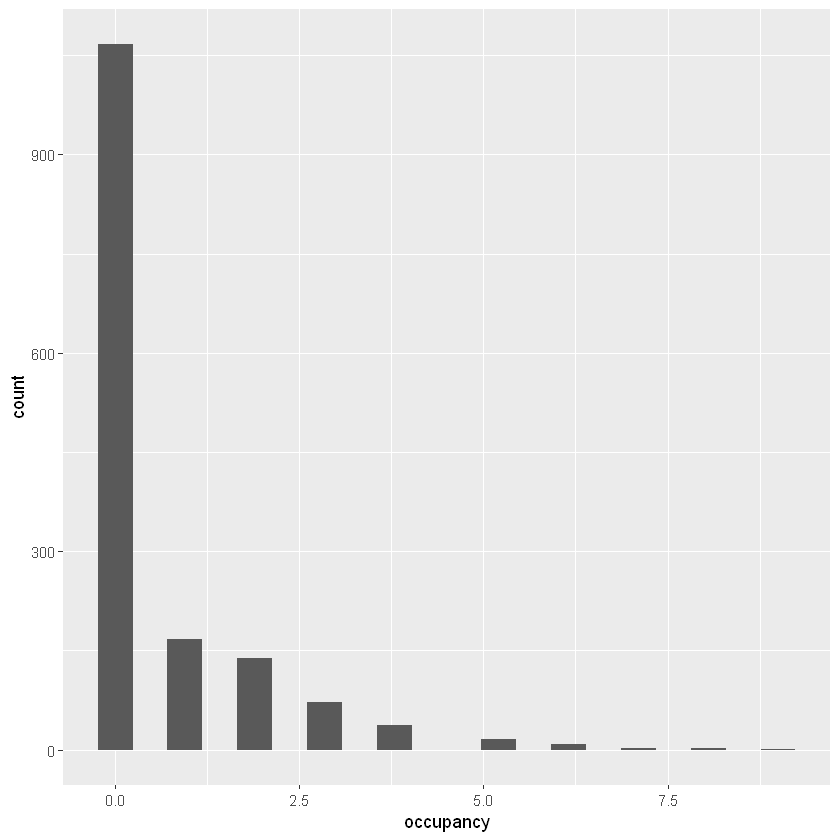

In [7]:
ggplot(data, aes(x = occupancy)) + geom_histogram(bins=20)

In [8]:
model_num <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room), data = data, family=poisson)

summary(model_num)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  3061.7   3077.7  -1527.8   3055.7     1510 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8759 -0.6826 -0.5893  0.4459  5.8866 

Random effects:
 Groups Name        Variance Std.Dev.
 room   (Intercept) 0.05292  0.23    
Number of obs: 1513, groups:  room, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.2441     0.1140  -10.91   <2e-16 ***
co2.rescaled   4.6107     0.1606   28.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.314

In [9]:
data_binary = read.csv("data_co2_occ_bin_filtered_30.csv")

colnames(data_binary)[colnames(data_binary) == 'sensor_name'] <- 'room'

In [10]:
head(data_binary)

,X,occupancy,room,co2,noise,humidity,temperature
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-11-20 08:00:00+00:00,0,ROOM 1,480.8556,50.85000,35.45825,21.30693
2,2019-11-20 08:30:00+00:00,0,ROOM 1,511.2000,52.91812,35.54536,21.45572
3,2019-11-20 09:00:00+00:00,1,ROOM 1,540.2248,53.10444,35.66022,21.72000
4,2019-11-20 09:30:00+00:00,1,ROOM 1,540.9333,55.15111,37.14889,21.72300
5,2019-11-20 10:00:00+00:00,0,ROOM 1,679.3540,50.02222,36.48111,21.54056
6,2019-11-20 10:30:00+00:00,1,ROOM 1,741.8699,50.43556,35.96489,21.81178


In [11]:
data_binary$co2.rescaled <- rescale(data_binary$co2) 

data_binary$day_of_week <- factor(weekdays(as.Date(data_binary$X)))

data_binary$time_cat <- cut(x=hour(data_binary$X), breaks = breaks, labels = labels, include.lowest=TRUE)

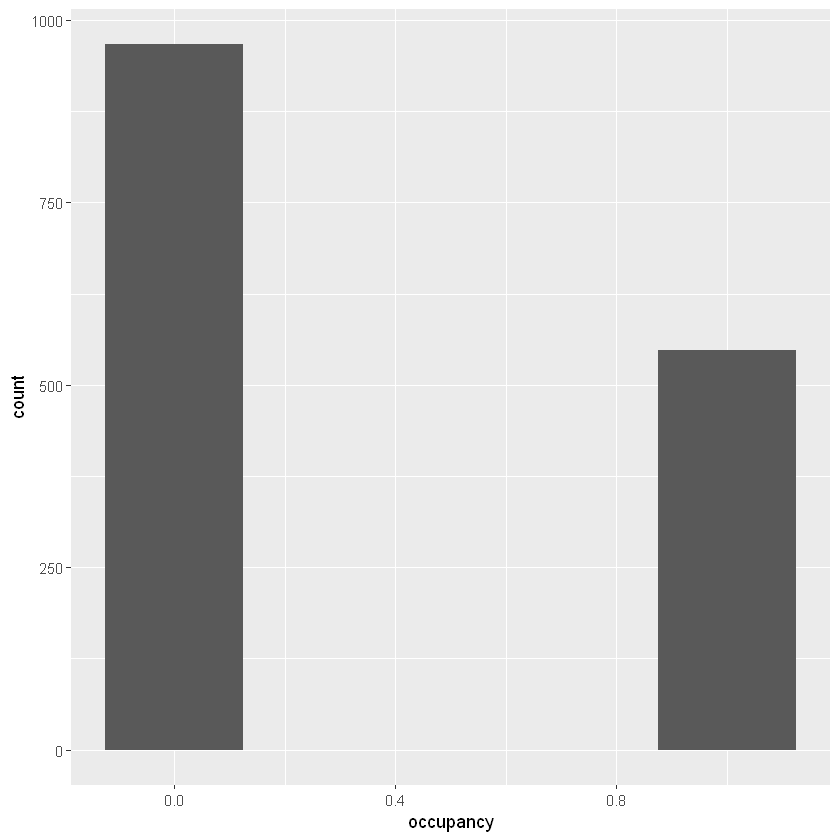

In [12]:
ggplot(data_binary, aes(x = occupancy)) + geom_histogram(bins=5)

In [13]:
model_bin <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room), data = data_binary, family=poisson)

summary(model_bin)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room)
   Data: data_binary

     AIC      BIC   logLik deviance df.resid 
  2194.8   2210.8  -1094.4   2188.8     1511 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0624 -0.5916 -0.5552  0.9747  1.4028 

Random effects:
 Groups Name        Variance Std.Dev.
 room   (Intercept) 0.01409  0.1187  
Number of obs: 1514, groups:  room, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.2157     0.0832 -14.611  < 2e-16 ***
co2.rescaled   1.4579     0.3253   4.482  7.4e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.571

# Hierarchical Model Equation

We introduce $i$ observations, $j$ groups

$\beta _{0j}$ and $\beta_{1j}$ are the intercept and slope (respectively) of the dependent variable in group $j$. Components $CO_2$ and $\epsilon_{ij}$ and predictor and error term, respectively.

First level:

$$ occupancy_{ij} = \beta_{0j} + \beta_{1j} \cdot CO_2 + \epsilon_{ij} $$

Second level:

$\gamma_{00}$ is the intercept and $\gamma_{10}$ is the slope, between the dependent variable and the Level 1 predictor. 
Components $u_{0j}$ and $u_{1j}$ are errors of intercept and slope.

Intercept:
$$\beta_{0j} = \gamma_{00} + u_{0j} $$

Slope:
$$ \beta_{1j} = \gamma_{10} + u_{1j} $$


## Poisson Regression

#### Occupancy measured in the number of people present

In [74]:
model_num_poiss <- brm(data = data, family = poisson,
                         occupancy ~ 1 + co2.rescaled + (1 | room),
                         iter = 2000, cores = 8, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

Start sampling



In [92]:
summary(model_num_poiss)

 Family: poisson 
  Links: mu = log 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.43      0.30     0.16     1.21 1.01      719     1078

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.24      0.23    -1.66    -0.78 1.00      925     1079
co2.rescaled     4.62      0.16     4.29     4.94 1.00     1790     1677

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

In [93]:
model_num_posterior_prob_pois <- posterior_interval(model_num_poiss,
                                            prob = 0.95)
round(model_num_posterior_prob_pois, 2)

,2.5%,97.5%
b_Intercept,-1.66,-0.78
b_co2.rescaled,4.29,4.94
sd_room__Intercept,0.16,1.21
Intercept,-1.11,-0.23
"r_room[ROOM.1,Intercept]",-0.84,0.09
"r_room[ROOM.2,Intercept]",-0.35,0.56
"r_room[ROOM.3,Intercept]",-0.67,0.25
"r_room[ROOM.4,Intercept]",-0.16,0.74
"r_room[ROOM.5,Intercept]",-0.40,0.52
lp__,-1541.32,-1531.68


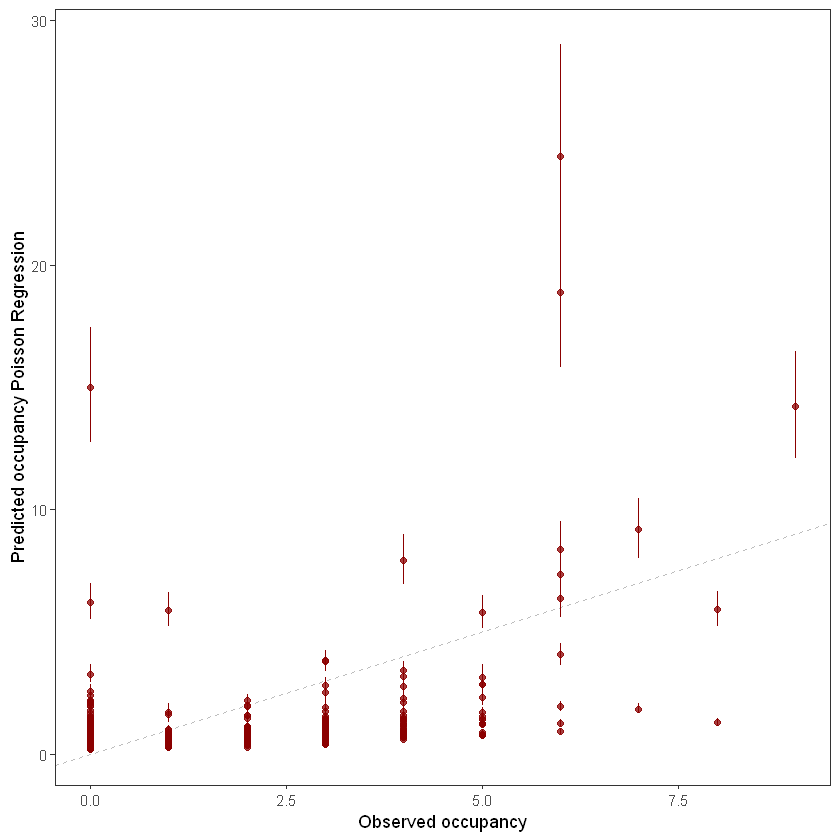

In [94]:
fitted(model_num_poiss) %>%
  as_tibble() %>%
  bind_cols(data)  %>%
  
  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Poisson Regression") +
  theme_bw() +
  theme(panel.grid = element_blank())

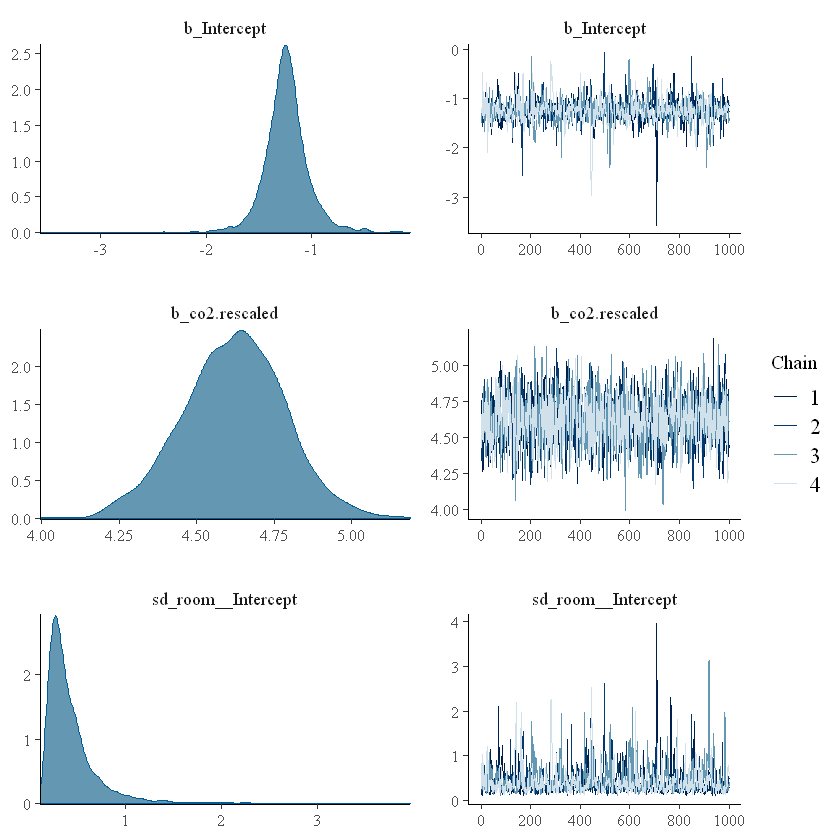

In [95]:
plot(model_num_poiss)

In [96]:
post_model_num_poiss <- posterior_samples(model_num_poiss, add_chain = T)
head(post_model_num_poiss)

,b_Intercept,b_co2.rescaled,sd_room__Intercept,Intercept,"r_room[ROOM.1,Intercept]","r_room[ROOM.2,Intercept]","r_room[ROOM.3,Intercept]","r_room[ROOM.4,Intercept]","r_room[ROOM.5,Intercept]",lp__,chain,iter
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,-1.205928,4.574483,0.1715715,-0.6531114,-0.26179779,0.08968183,-0.11273167,0.3038980,0.1510342,-1538.530,1,1001
2,-1.360956,4.512817,0.2166284,-0.8155916,-0.34886952,0.13006682,-0.11812045,0.4694393,0.2484333,-1540.346,1,1002
3,-1.315268,4.758511,0.1289595,-0.7402123,-0.13883460,0.14595379,-0.14488552,0.2757863,0.0676304,-1540.293,1,1003
4,-1.339362,4.761397,0.1357508,-0.7639574,-0.14159944,0.15903976,-0.15341804,0.2738782,0.1066307,-1539.835,1,1004
5,-1.537763,4.485917,0.3361391,-0.9956499,-0.09031099,0.43125927,0.06834720,0.5768825,0.3998147,-1536.701,1,1005
6,-1.293747,4.267170,0.1693201,-0.7780693,-0.29540118,0.09513012,0.03868084,0.3616621,0.1791888,-1540.723,1,1006


#### Occupancy measured in binary terms: ocuppied / not occupied

In [97]:
model_bin_poiss <- brm(data = data_binary, family = poisson,
                         occupancy ~ 1 + co2.rescaled + (1 | room),
                         iter = 2000, cores = 8, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [98]:
summary(model_bin_poiss)

 Family: poisson 
  Links: mu = log 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data_binary (Number of observations: 1514) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.18     0.04     0.71 1.01      561      893

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.23      0.14    -1.53    -0.98 1.01      921      895
co2.rescaled     1.49      0.34     0.83     2.13 1.00     2094     2070

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

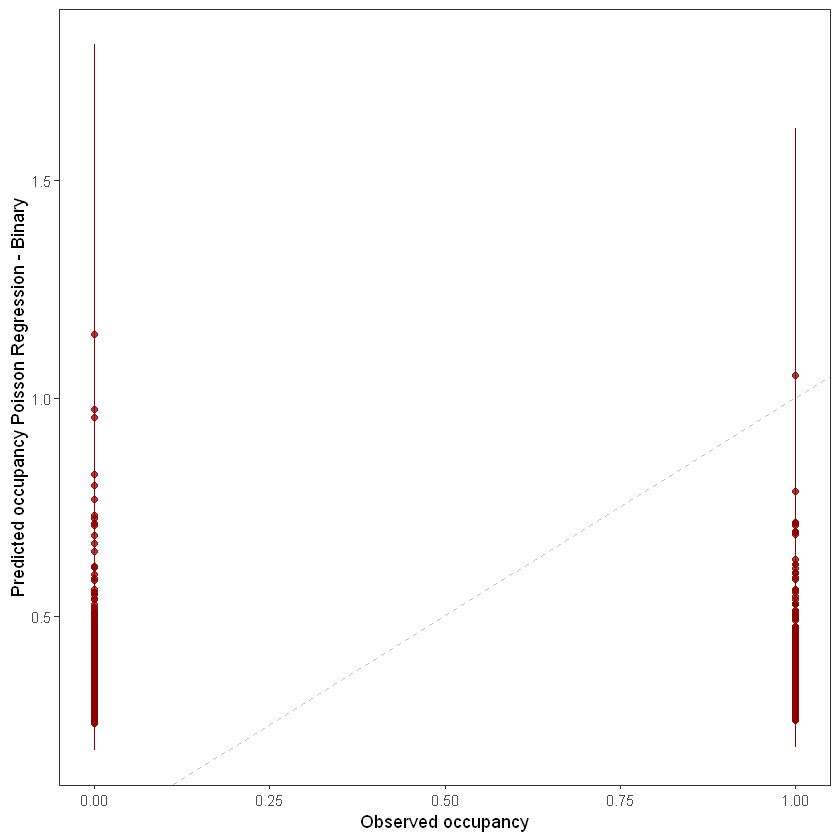

In [99]:
fitted(model_bin_poiss) %>%
  as_tibble() %>%
  bind_cols(data_binary)  %>%
  
  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Poisson Regression - Binary") +
  theme_bw() +
  theme(panel.grid = element_blank())

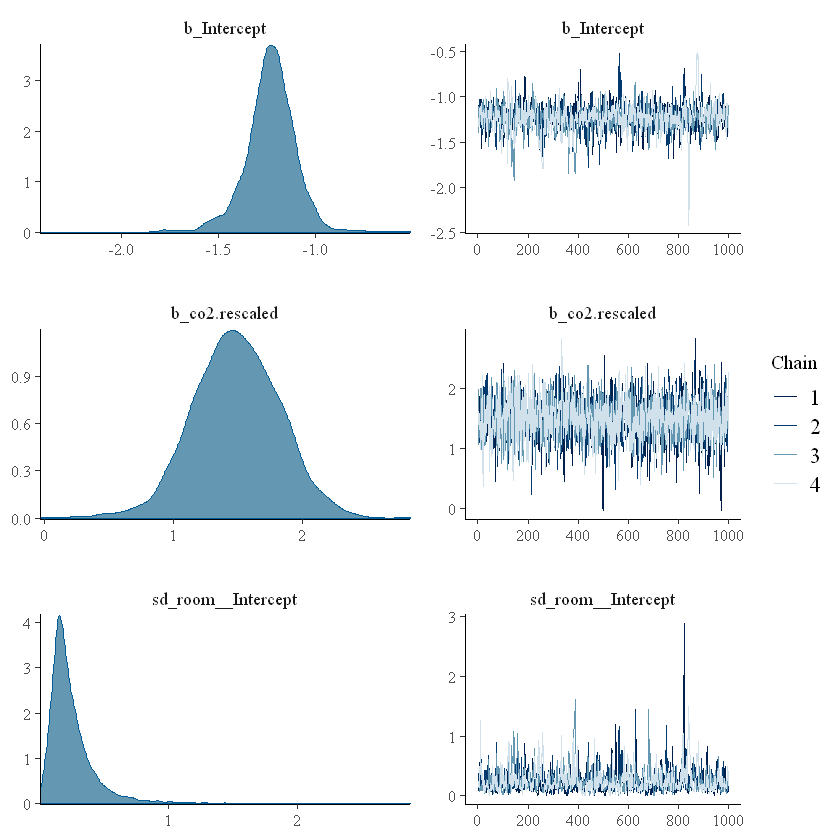

In [100]:
plot(model_bin_poiss)

# Negative Binomial Regression
#### Occupancy measured in the number of people present

In [107]:
model_num_negbinomial <- brm(data = data, family = negbinomial,
                       occupancy ~ 1 + co2.rescaled + (1 | room), iter = 2000,
                       cores = 8, control = list(adapt_delta = 0.99999999, max_treedepth=20), seed = 334)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [108]:
summary(model_num_negbinomial)

 Family: negbinomial 
  Links: mu = log; shape = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.55      0.41     0.19     1.61 1.01      676      937

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -2.07      0.33    -2.67    -1.43 1.00      926     1096
co2.rescaled     9.45      0.59     8.34    10.67 1.00     2205     1951

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     0.88      0.10     0.71     1.09 1.00     2267     2152

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rh

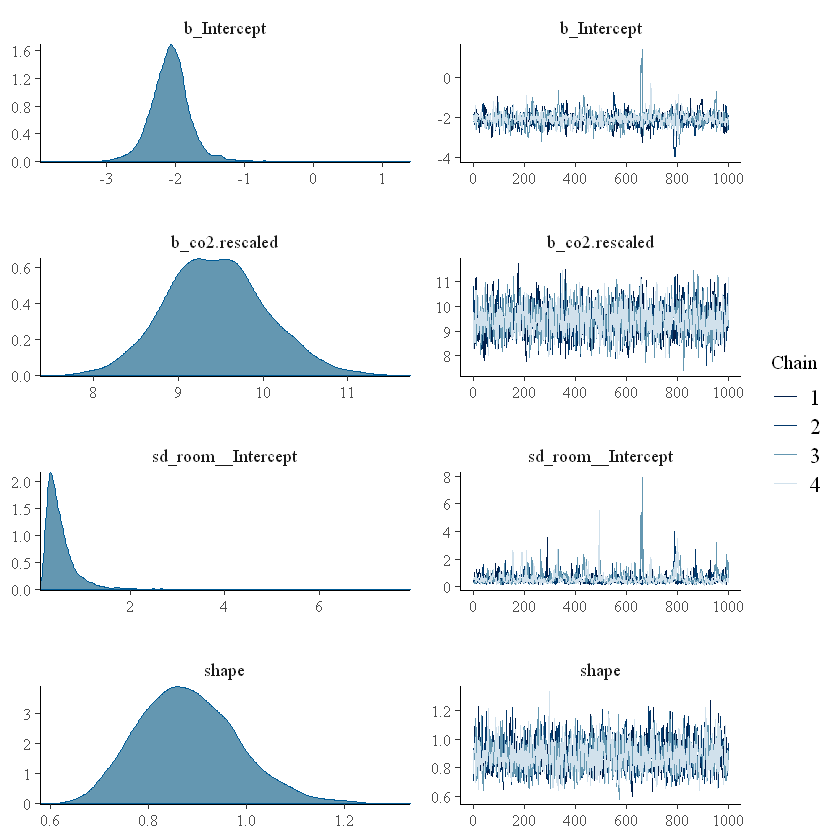

In [109]:
plot(model_num_negbinomial)

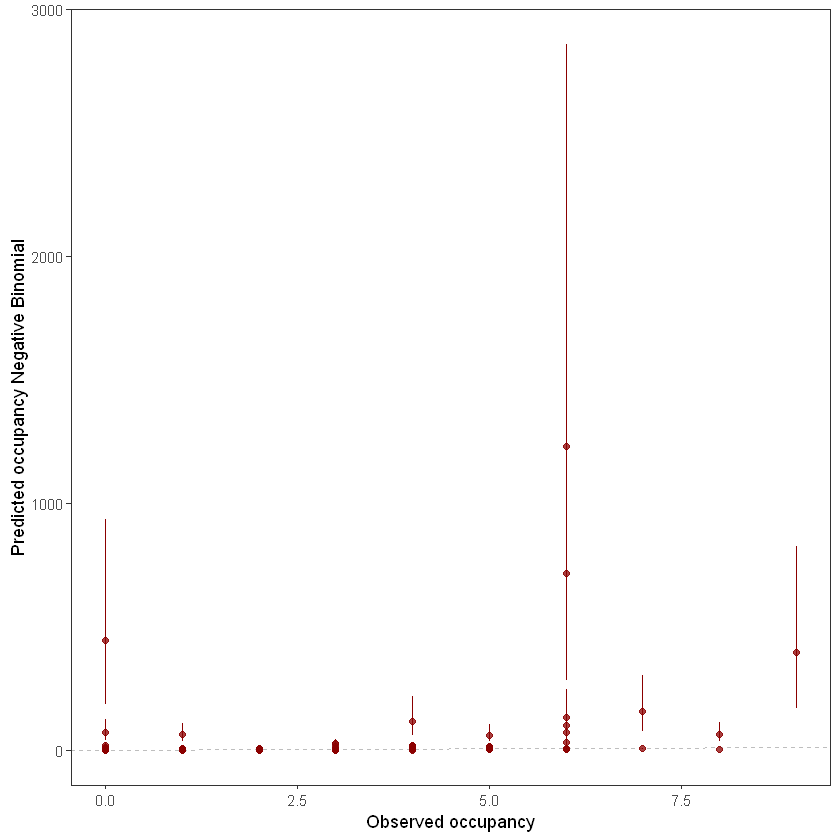

In [110]:
fitted(model_num_negbinomial) %>%
  as_tibble() %>%
  bind_cols(data)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Negative Binomial") +
  theme_bw() +
  theme(panel.grid = element_blank())

#### Occupancy measured in binary terms: ocuppied / not occupied

In [111]:
model_bin_negbinomial <- brm(data = data_binary, family = negbinomial,
                         occupancy ~ 1 + co2.rescaled + (1 | room),
                         iter = 2000, cores = 8, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [113]:
summary(model_bin_negbinomial)

 Family: negbinomial 
  Links: mu = log; shape = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data_binary (Number of observations: 1514) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.23      0.18     0.03     0.71 1.00      742     1064

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.23      0.15    -1.52    -0.95 1.00     1202     1201
co2.rescaled     1.50      0.33     0.85     2.14 1.00     2644     2515

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   126.10     88.91    29.64   363.45 1.00     2841     2454

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size,

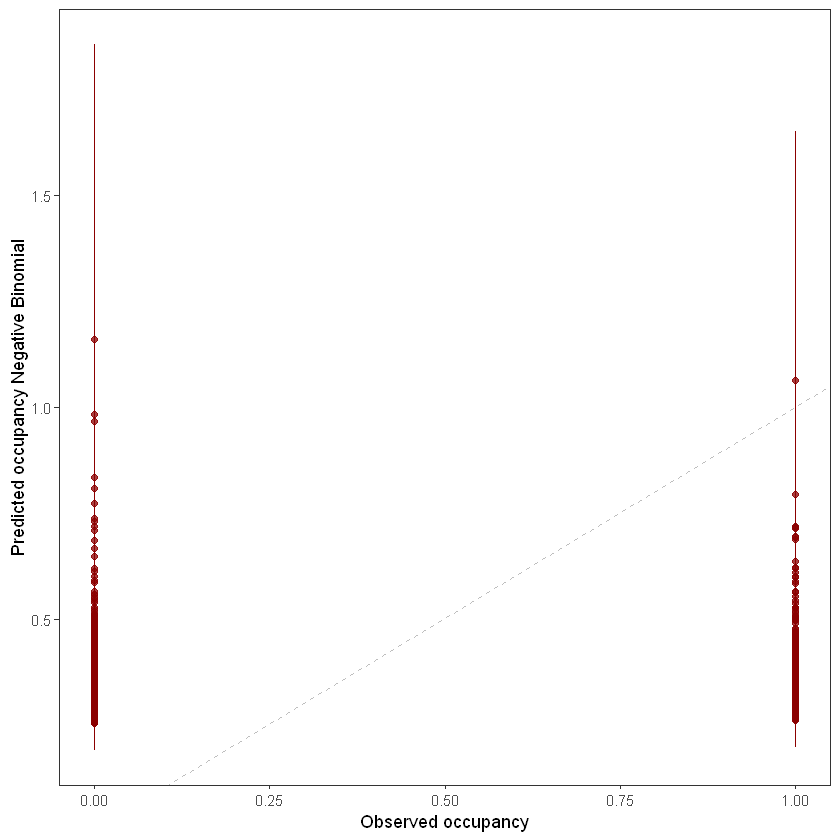

In [114]:
fitted(model_bin_negbinomial) %>%
  as_tibble() %>%
  bind_cols(data_binary)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Negative Binomial") +
  theme_bw() +
  theme(panel.grid = element_blank())

## Zero Inflated Poisson model
#### Occupancy measured in the number of people present

In [88]:
model_num_zero_inflated_poisson <- brm(data = data, family = zero_inflated_poisson,
                                       occupancy ~ 1 + co2.rescaled + (1 | room), iter = 3000,
                                       cores = 8, control = list(adapt_delta = 0.9999999), seed = 334)

Compiling the C++ model

Start sampling



In [89]:
summary(model_num_zero_inflated_poisson)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup samples = 6000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.40      0.24     0.15     1.03 1.00     1310     2172

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.48      0.21    -0.90    -0.05 1.00     1521     1973
co2.rescaled     3.67      0.21     3.26     4.09 1.00     2776     3384

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.49      0.03     0.43     0.54 1.00     3331     3421

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and R

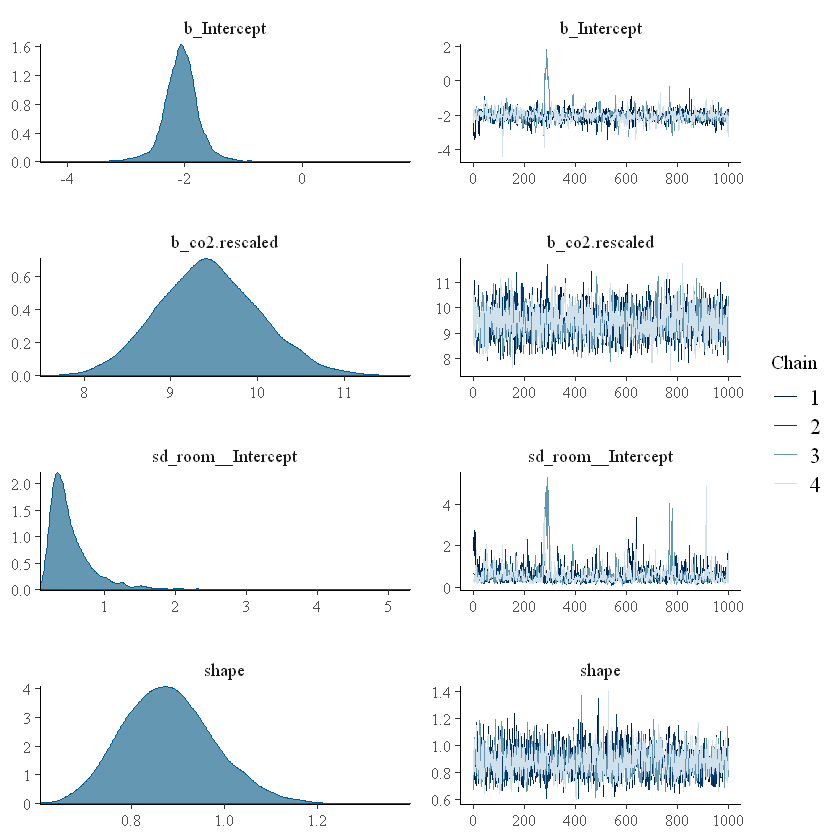

In [91]:
plot(model_num_negbinomial)

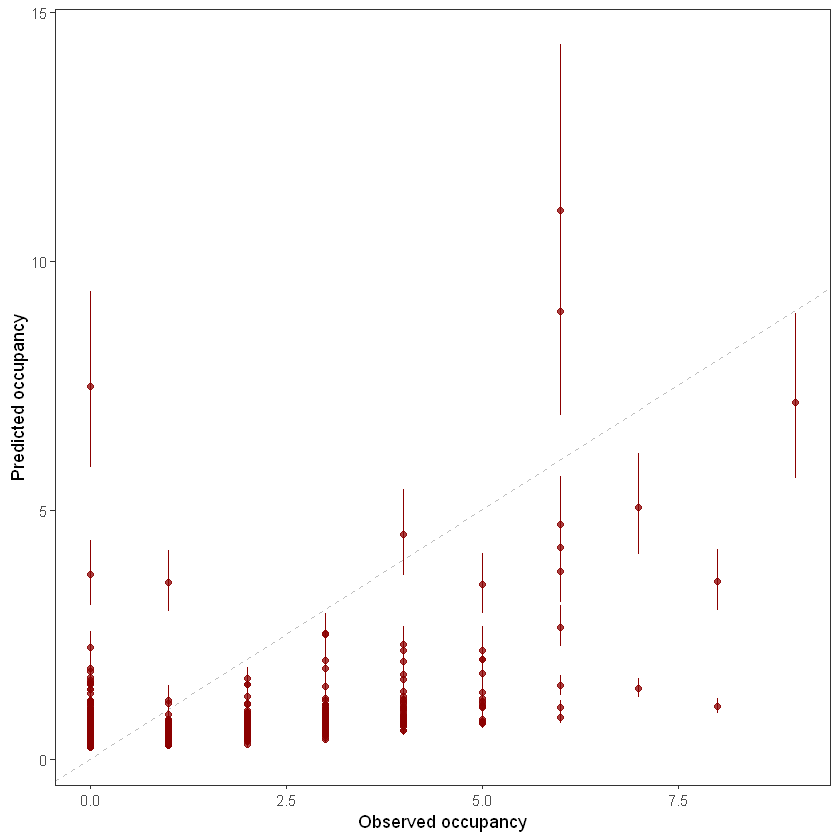

In [90]:
fitted(model_num_zero_inflated_poisson) %>%
  as_tibble() %>%
  bind_cols(data)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Zero Inflated Poisson") +
  theme_bw() +
  theme(panel.grid = element_blank())

## Adding day of the week as a covariate

In [ ]:
model_num_zero_inflated_poisson_day <- brm(data = data, family = zero_inflated_poisson,
                                           occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week), iter = 1000,
                                           cores = 1, control = list(adapt_delta = 0.9999999), seed = 334)

#### Output produced in RStudio

```
Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) 
   Data: data (Number of observations: 6449) 
Samples: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup samples = 6000

Group-Level Effects: 
~day_of_week (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.31      0.20     0.12     0.82 1.00     1491     2717

~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.48      0.32     0.19     1.32 1.00     1424     2216

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.76      0.29    -1.33    -0.18 1.00     2284     2322
co2.rescaled     4.60      0.14     4.32     4.89 1.00     4526     4306

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.68      0.01     0.65     0.71 1.00     4666     3624

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).
```
<img src="Rplot_zero_inf_pois_day.jpeg" height="800" width="600">


## Adding day of the week and time of the day as a covariate

In [ ]:
model_num_zero_inflated_poisson_time <- brm(data = data, family = zero_inflated_poisson,
                                            occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat),
                                            iter = 3000, cores = 1, control = list(adapt_delta = 0.9), seed = 334)

#### Occupancy measured in binary terms: ocuppied / not occupied

In [106]:
model_bin_zero_inflated_poisson <- brm(data = data_binary, family = zero_inflated_poisson,
                                       occupancy ~ 1 + co2.rescaled + (1 | room),
                                       iter = 2000, cores = 8, seed = 334,
                                       control = list(adapt_delta = 0.999999999, max_treedepth=20))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [115]:
summary(model_bin_zero_inflated_poisson)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data_binary (Number of observations: 1514) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.23      0.17     0.03     0.70 1.01      648      813

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.21      0.15    -1.49    -0.95 1.00      985      988
co2.rescaled     1.49      0.33     0.85     2.10 1.00     2618     2788

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.01      0.01     0.00     0.03 1.00     2334     1087

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size

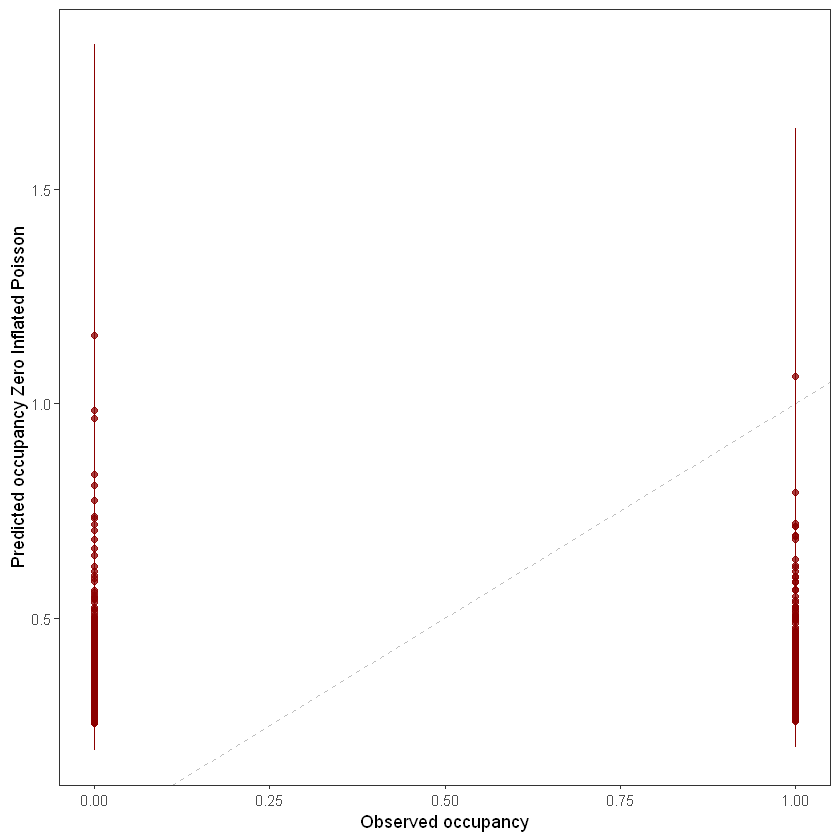

In [116]:
fitted(model_bin_zero_inflated_poisson) %>%
  as_tibble() %>%
  bind_cols(data_binary)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Zero Inflated Poisson") +
  theme_bw() +
  theme(panel.grid = element_blank())

## Leave-one-out cross-validation 
#### Occupancy measured in the number of people present

In [117]:
loo_model_num_poiss <- loo(model_num_poiss, k_threshold = 0.7, reloo = TRUE, cores = getOption("mc.cores", 1))
loo_model_num_negbinomial <- loo(model_num_negbinomial, k_threshold = 0.7, cores = getOption("mc.cores", 1))
loo_model_num_zero_inflated_poisson <-loo(model_num_zero_inflated_poisson, k_threshold = 0.7, cores = getOption("mc.cores", 1))

loo_compare(loo_model_num_poiss, loo_model_num_negbinomial, loo_model_num_zero_inflated_poisson)

1 problematic observation(s) found.
The model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 695)

Start sampling



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_num_negbinomial,0.00000,0.00000,-1373.334,42.18276,6.244429,0.4513411,2746.668,84.36552
model_num_zero_inflated_poisson,-54.63798,13.90171,-1427.972,41.31692,10.717593,3.2180165,2855.944,82.63383
model_num_poiss,-156.77132,21.60953,-1530.106,47.35950,14.520802,3.7716811,3060.211,94.71901


In [128]:
loo_model_num_poiss


Computed from 4000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1530.1 47.4
p_loo        14.5  3.8
looic      3060.2 94.7
------
Monte Carlo SE of elpd_loo is 0.2.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     1512  99.9%   27        
 (0.5, 0.7]   (ok)          1   0.1%   316       
   (0.7, 1]   (bad)         0   0.0%   <NA>      
   (1, Inf)   (very bad)    0   0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

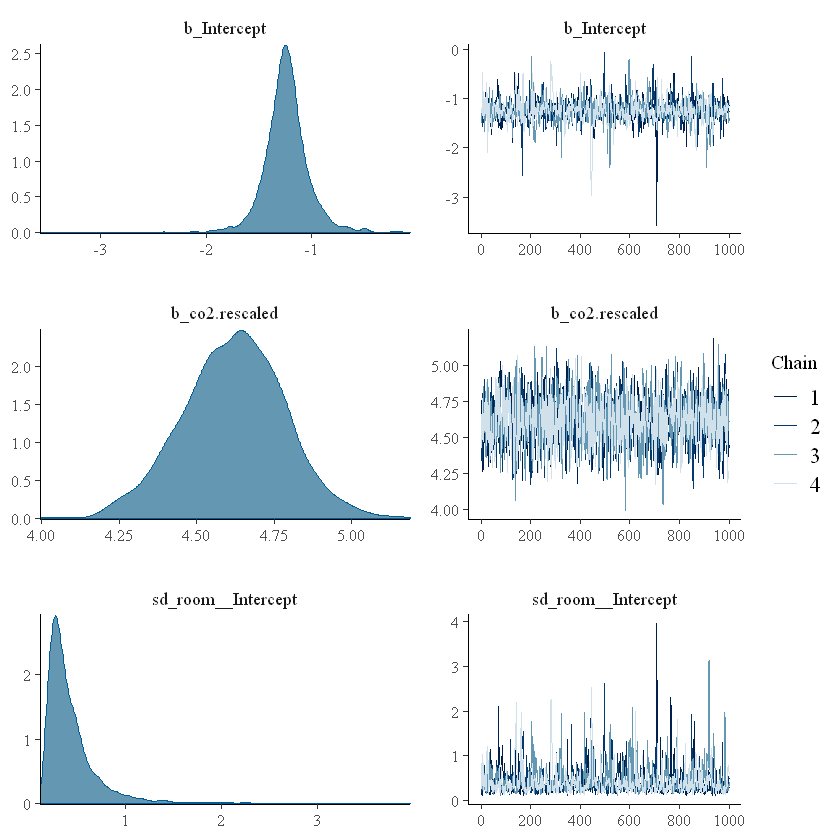

In [119]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(model_num_poiss, label_points = TRUE)

In [120]:
loo_model_num_negbinomial


Computed from 4000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1373.3 42.2
p_loo         6.2  0.5
looic      2746.7 84.4
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

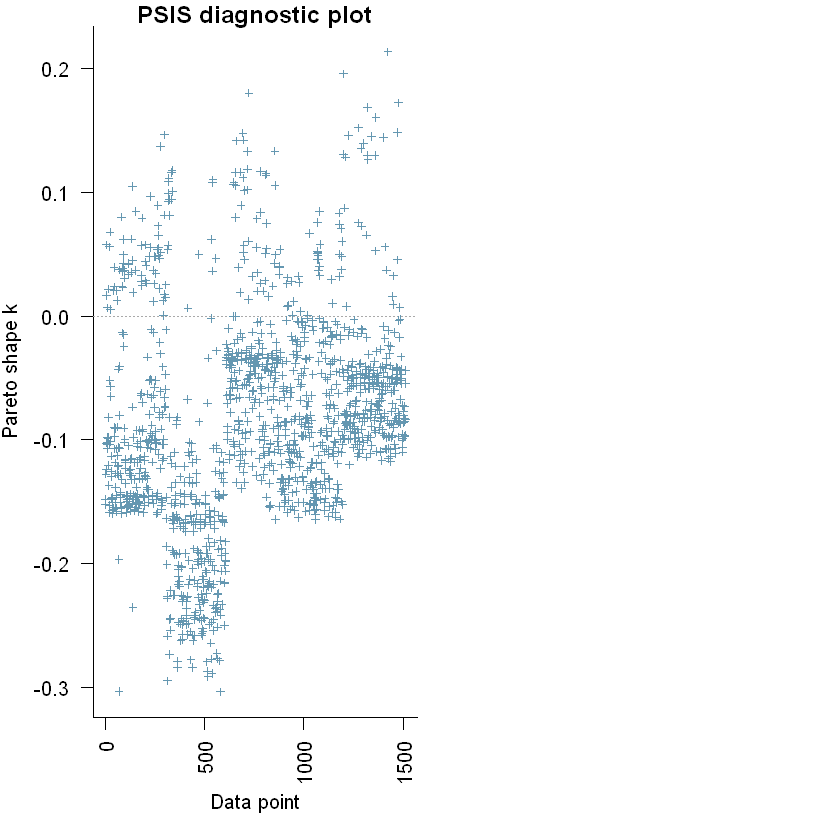

In [121]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(loo_model_num_negbinomial, label_points = TRUE)

In [122]:
loo_model_num_zero_inflated_poisson


Computed from 6000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1428.0 41.3
p_loo        10.7  3.2
looic      2855.9 82.6
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     1512  99.9%   797       
 (0.5, 0.7]   (ok)          1   0.1%   161       
   (0.7, 1]   (bad)         0   0.0%   <NA>      
   (1, Inf)   (very bad)    0   0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

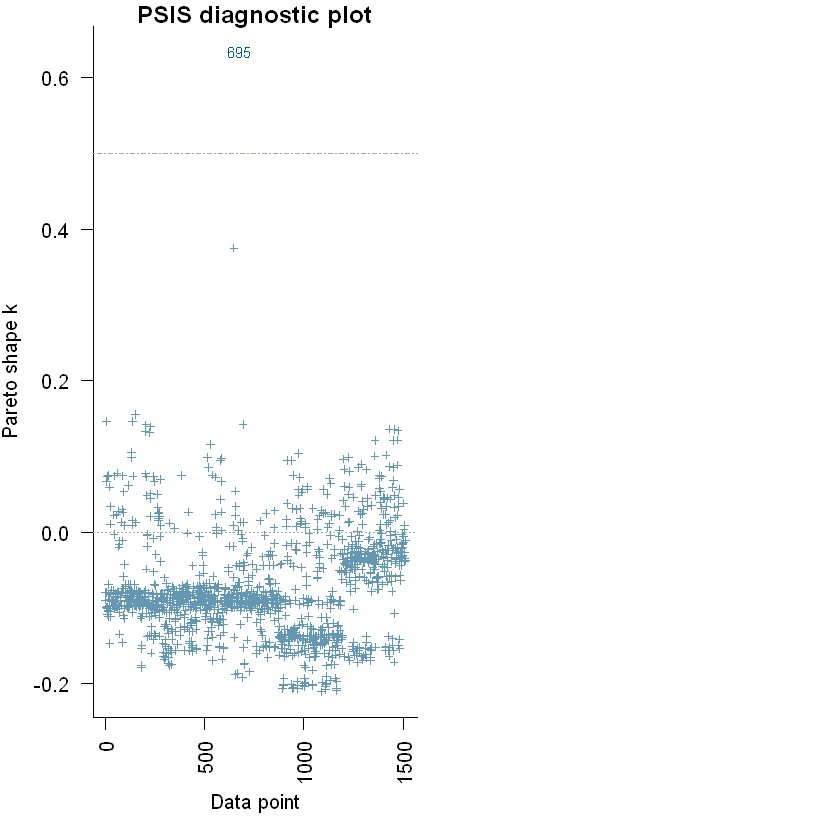

In [123]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(loo_model_num_zero_inflated_poisson, label_points = TRUE)

#### Occupancy measured in binary terms: ocuppied / not occupied

In [124]:
loo_model_bin_poiss <- loo(model_bin_poiss, k_threshold = 0.7, reloo = TRUE, cores = getOption("mc.cores", 1))
loo_model_bin_negbinomial <- loo(model_bin_negbinomial, k_threshold = 0.7, cores = getOption("mc.cores", 1))
loo_model_bin_zero_inflated_poisson <-loo(model_bin_zero_inflated_poisson, k_threshold = 0.7, cores = getOption("mc.cores", 1))

loo_compare(loo_model_bin_poiss, loo_model_bin_negbinomial, loo_model_bin_zero_inflated_poisson)

No problematic observations found. Returning the original 'loo' object.



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_bin_poiss,0.000000,0.00000000,-1094.463,19.45776,3.426745,0.1362432,2188.927,38.91552
model_bin_zero_inflated_poisson,-1.124867,0.09411588,-1095.588,19.50598,3.465844,0.1314593,2191.176,39.01197
model_bin_negbinomial,-1.276085,0.11777374,-1095.739,19.55878,3.431534,0.1342959,2191.479,39.11755


In [125]:
loo_model_bin_poiss


Computed from 4000 by 1514 log-likelihood matrix

         Estimate   SE
elpd_loo  -1094.5 19.5
p_loo         3.4  0.1
looic      2188.9 38.9
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [126]:
loo_model_bin_negbinomial


Computed from 4000 by 1514 log-likelihood matrix

         Estimate   SE
elpd_loo  -1095.7 19.6
p_loo         3.4  0.1
looic      2191.5 39.1
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [127]:
loo_model_bin_zero_inflated_poisson


Computed from 4000 by 1514 log-likelihood matrix

         Estimate   SE
elpd_loo  -1095.6 19.5
p_loo         3.5  0.1
looic      2191.2 39.0
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [ ]:
example(brm,run.dontrun = TRUE)

In [12]:
model_bin_zero_inflated_poisson_day <- brm(data = data_binary, family = zero_inflated_poisson,
                                           occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week), iter = 2000,
                                           cores = 1, control = list(adapt_delta = 0.9999999), seed = 334)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '1b7a8c28d8362d1d4580834442a56f34' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 65.551 seconds (Warm-up)
Chain 1:                62.358 seconds (Sampling)
Chain 1:

In [13]:
summary(model_bin_zero_inflated_poisson_day)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) 
   Data: data_binary (Number of observations: 1514) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~day_of_week (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.22     0.04     0.74 1.00      742      972

~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.24     0.04     0.73 1.01      746     1062

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.20      0.22    -1.60    -0.78 1.00     1166      919
co2.rescaled     1.44      0.33     0.77     2.08 1.00     2430     2489

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% C

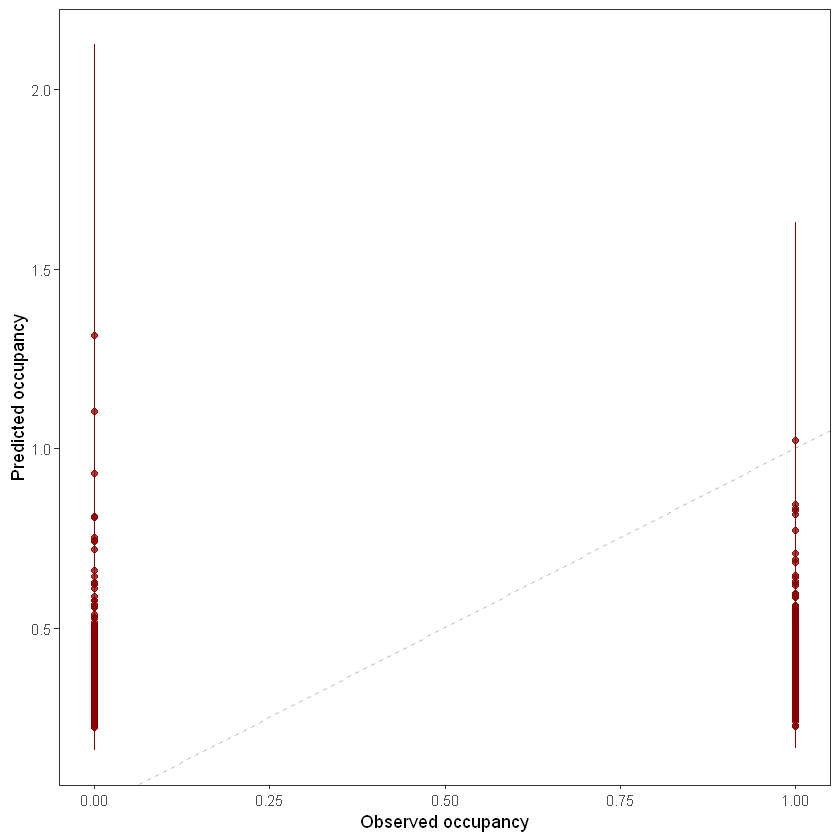

In [14]:
fitted(model_bin_zero_inflated_poisson_day) %>%
  as_tibble() %>%
  bind_cols(data_binary)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy") +
  theme_bw() +
  theme(panel.grid = element_blank())

In [ ]:
model_bin_zero_inflated_poisson_time <- brm(data = data_binary, family = zero_inflated_poisson,
                                            occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat),
                                            iter = 2000, cores = 1, control = list(adapt_delta = 0.9), seed = 334)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling

